# Imaging analysis

We start with some preparatory steps. Uncomment these commands or run them on terminal, making sure you have loaded the heasoft environment

In [ ]:
user_name = 'samueleronchini'
# root = f'/home/idies/workspace/Storage/{user_name}/persistent'
root = '/Users/sjs8171/Desktop/bat_glimpse'

In [ ]:
# %cd {root}
# ! git clone https://github.com/Swift-BAT/NITRATES.git
# %cd NITRATES
# ! git fetch origin
# ! git switch -c acme origin/acme
# ! git branch
# ! pip install -e .
# ! pip install BatAnalysis 

Edit here trigid and trigger_time . We start analysing this GRB 241105A https://gcn.nasa.gov/circulars/38091

In [192]:
trigid = '752515599_c0'
triggertime = '2024-11-05T16:06:04.660000'

In [193]:
# root = f'/home/idies/workspace/Storage/{user_name}/persistent'
# root = '/Users/sjs8171/Desktop/bat_glimpse'
# create data directory and work dir if it does not exist
import os

# data_dir = f'{root}/{trigid}/data'
data_dir = f'{root}/data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

workdir = f'{root}/{trigid}'

if not os.path.exists(workdir):
    os.makedirs(workdir)
    
def filter_data(obsid):
    command = f'python -m nitrates.data_prep.mkdb --work_dir {workdir} '
    ! echo {command}
    ! {command}
    
    command = '' \
    '' \
    'python -m nitrates.data_prep.do_data_setup ' \
    f'--work_dir {workdir}' \
    f' --trig_time {triggertime}' \
    f' --evfname {root}/data/{obsid}/bat/event/sw{obsid}bevshsl_uf.evt.gz' \
    f' {root}/data/{obsid}/bat/event/sw{obsid}bevshpo_uf.evt.gz' \
    f' --dmask {root}/data/{obsid}/bat/hk/sw{obsid}bdecb.hk.gz' \
    f' --att_fname {root}/data/{obsid}/auxil/sw{obsid}pat.fits.gz' \
    f' --acs_fname {root}/data/{obsid}/auxil/sw{obsid}pat.fits.gz' \
    f' --data_dbfname {workdir}/results.db'
    
    ! echo {command}
    ! {command}

We first get data from GUANO, using swifttools. For a complete guide to use GUANO API, see https://www.swift.psu.edu/too_api/index.php?md=Swift%20GUANO%20Example%20Notebook.ipynb

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import os
import batanalysis as ba

import logging
import time
from pathlib import Path
import traceback
from swifttools.swift_too import GUANO, Clock, Data

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

import warnings
warnings.filterwarnings("ignore")



def guano_query(triggertime, ext_obsid, workdir, datadir):

    if '.' not in triggertime.split('T')[1]:
        triggertime = triggertime + '.000Z'
    else:
        triggertime = triggertime + 'Z'

    logging.info(f'Using triggertime: {triggertime}')

    guano = GUANO(triggertime=triggertime, successful = False)

    logging.info(guano)

    for item in guano: # this loop is required if multiple triggers are associated with the same obsid
        logging.info(f'running {item}')

        if item.data.exposure is None:
            logging.error(f'No exposure time found for obsid {item.obsid}. Skipping this obsid.')
            exit()

        if ext_obsid is not None:
            obsid = ext_obsid
        else:
            obsid = item.obsid

        start_time_try = time.time()
        event = None
        while time.time() - start_time_try < 1800 and event is None:
            try:
                '''
                We need to remove any data or results already existing, since BatAnalysis can have problems
                '''
                # Remove directories if they exist
                obsid_dir = f"{datadir}/{obsid}"
                obsid_eventresult_dir = f"{datadir}/{obsid}_eventresult"
                if os.path.exists(obsid_dir):
                    os.system(f"rm -rf {obsid_dir}")
                if os.path.exists(obsid_eventresult_dir):
                    os.system(f"rm -rf {obsid_eventresult_dir}")


                data = Data(obsid=obsid, bat=True, outdir=datadir, clobber=True, uksdc=True)
                logging.info(data)
                ba.datadir(datadir)
                event = ba.BatEvent(obsid, is_guano=True)

                # filter data using nitrates
                filter_data(obsid)
                
                # We use here the filtered files produced by NITRATES
                event.detector_quality_file = Path(f'{workdir}/detmask.fits')
                event.event_files = Path(f'{workdir}/filter_evdata.fits')
                event.attitude_file = Path(f'{workdir}/attitude.fits')

                event._parse_event_file()

                ba.mosaic._pcodethresh = 0.01  

            except Exception:
                logging.error(f"Failed to create Data and BatEvent for obsid {obsid}: {traceback.format_exc()}")
    
    return event


## Data preparation

In [195]:
event = guano_query(triggertime, None, workdir, data_dir)

2025-12-18 12:22:16,497 - INFO - Using triggertime: 2024-11-05T16:06:04.660000Z
2025-12-18 12:22:17,398 - INFO - +--------------+----------------------------+------------+---------------------+----------------+
| Trigger Type |               Trigger Time | Offset (s) | Window Duration (s) | Observation ID |
+--------------+----------------------------+------------+---------------------+----------------+
|      GBM GRB | 2024-11-05 16:06:04.660000 |       50.0 |               200.0 |    00018897003 |
+--------------+----------------------------+------------+---------------------+----------------+
2025-12-18 12:22:17,401 - INFO - running +-------------+----------------------------+
|   Parameter |                      Value |
+-------------+----------------------------+
| triggertime | 2024-11-05 16:06:04.660000 |
| triggertype |                    GBM GRB |
|      offset |                       50.0 |
|    duration |                      200.0 |
|   quadsaway |                   1449112

2025-12-18 12:22:29,709 - INFO - +-------------------------+-----------------------------------------+-----------------------------------------+
|                    Path |                                Filename |                             Description |
+-------------------------+-----------------------------------------+-----------------------------------------+
|       00018897003/auxil | SWIFT_TLE_ARCHIVE.txt.24317.95387196.gz |                      Auxillary TLE file |
|                      '' |                sw00018897003pat.fits.gz |                 Auxillary attitude file |
|                      '' |                 sw00018897003pjb.par.gz |                          Auxillary file |
|                      '' |                 sw00018897003pob.cat.gz |                       Auxillary catalog |
|                      '' |                 sw00018897003ppr.par.gz |                          Auxillary file |
|                      '' |                   sw00018897003s.mkf.gz |  

A save file has been written to /Users/sjs8171/Desktop/bat_glimpse/data/00018897003_eventresult/batevent.pickle.


Convert the t0 from UTC to MET

In [196]:
t0 = Clock(utctime=triggertime+'Z').met

## Visualising the attitude info

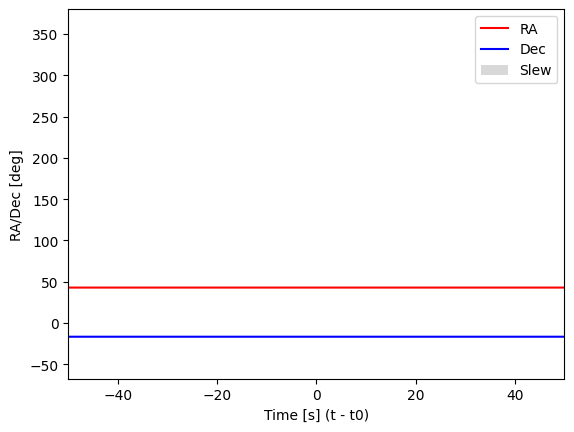

In [197]:

plt.plot(event.attitude.time.value-t0, event.attitude.ra, label='RA', color='red')
plt.plot(event.attitude.time.value-t0, event.attitude.dec, label='Dec', color='blue')

# Identify intervals where RA and Dec change
ra_diff = np.diff(event.attitude.ra.value)
dec_diff = np.diff(event.attitude.dec.value)
margin = 1 / 60  # Margin of 1/60 degree, i.e., 1 arcmin
change_indices = np.where((np.abs(ra_diff) > margin) | (np.abs(dec_diff) > margin))[0]

for idx in change_indices:
    plt.axvspan(event.attitude.time[idx].value - t0, event.attitude.time[idx + 1].value - t0, color='gray', alpha=0.3, linewidth=0, label='Slew' if idx == change_indices[0] else None)

plt.xlim(-50, 50)
plt.xlabel("Time [s] (t - t0)")
plt.ylabel("RA/Dec [deg]")
plt.legend()
plt.show()
plt.savefig(f'{workdir}/attitude.png', dpi=500)
plt.close()

## Check the external position with respect to BAT FOV

We first need to downloea the Fermi-GBM map:

In [150]:
output_file = os.path.join(workdir, 'ext_loc_fermi.fit')
! curl -o {output_file} https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2024/bn241105671/quicklook/glg_healpix_all_bn241105671.fit

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1549k  100 1549k    0     0   267k      0  0:00:05  0:00:05 --:--:--  397k


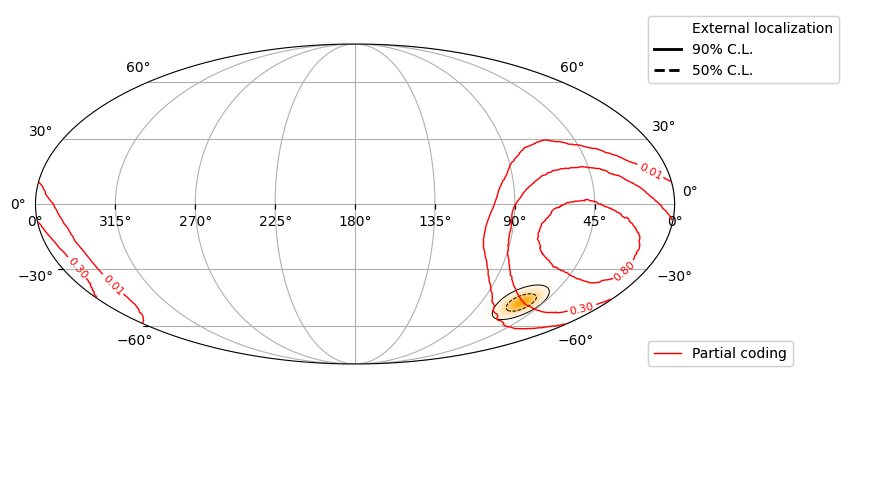

In [198]:
from matplotlib.lines import Line2D
import ligo.skymap.io
import ligo.skymap.plot
import ligo.skymap.postprocess

from matplotlib.colors import LinearSegmentedColormap


def map_ext(fit_file, workdir, ax_globe):

    skymap, _ = ligo.skymap.io.fits.read_sky_map(os.path.join(workdir, fit_file), nest=True, distances=False)
    skymap_prob = skymap.copy()

    white_to_blue = LinearSegmentedColormap.from_list("whiteblue", ["white", "orange"])

    ax_globe.imshow_hpx((skymap_prob, 'ICRS'), cmap=white_to_blue, alpha=1.0, nested=True, zorder=0)

    cls = 100 * ligo.skymap.postprocess.util.find_greedy_credible_levels(skymap)
    
    ax_globe.contour_hpx((cls, 'ICRS'), nested=True, colors='black',
                        levels=(50, 90), zorder=0,
                        linestyles=['dashed', 'solid'],
                        linewidths=0.7)

    loc_line = [
        Line2D([0], [0], color='red', linestyle='dotted', linewidth=2, label='External localization', alpha=.0),
        Line2D([0], [0], color='black', linestyle='solid', linewidth=2, label='90% C.L.'),
        Line2D([0], [0], color='black', linestyle='dashed', linewidth=2, label='50% C.L.')
    ]

    return loc_line


def map_imaging(event, t0, workdir):


    fig = plt.figure(figsize=(11, 5))

    ax_globe = fig.add_axes([
        0.05,  # left
        0.10,  # bottom
        0.68,  # width
        0.80   # height
    ], projection='astro degrees mollweide')

    '''
    We create a sky image and extract partial coding
    '''


    skyview = event.create_skyview(timebins=[0,1]*u.s, energybins=[15,350]*u.keV,
                                    is_relative=True, recalc = True, T0=t0)
    
    t = skyview.pcode_img # We extract the partial coding image

    hp_proj = t.healpix_projection(coordsys="icrs", nside=1024) # projecting in healpix (from BAT FOV coords to sky coords)

    '''
    The hp_proj object contains the healpix projection of the sky image.
    It is an array that contains [time, sky pixel, energy band]. 
    Since we created a single sky image for a single time bin and a single energy band,
    we can extract the first time and first energy band to get the sky map.
    '''

    plot_quantity_pc = hp_proj.contents[0,:,0]

    # Contour partial coding
    cs = ax_globe.contour_hpx((plot_quantity_pc, 'ICRS'), nested=False,
                                colors='red', levels=[0.01,0.3,0.8],
                                linewidths=1, zorder=2)
    

    '''
    External localization
    '''

    fit_file = next((fname for fname in os.listdir(workdir) if 'ext_loc' in fname), None)
    loc_handles = None
    if fit_file:
        loc_handles = map_ext(fit_file, workdir, ax_globe)
        

    # Here some aestethic adjustments

    ax_globe.clabel(cs, inline=True, fmt='%1.2f', fontsize=8)
    ax_globe.grid()
    ax_globe.set_position([0.08, 0.12, 0.84, 0.64])
    # Handles per la legenda del partial coding
    red_line = [Line2D([0], [0], color='red', lw=1, label='Partial coding')]
    ax_leg_top = fig.add_axes([0.76, 0.55, 0.22, 0.28])
    ax_leg_top.axis('off')
    if loc_handles is not None:
        leg_ext = ax_leg_top.legend(handles=loc_handles, loc='upper left', frameon=True, borderaxespad=0.5)
        ax_leg_top.add_artist(leg_ext)
    ax_leg_bot = fig.add_axes([0.76, -0.1, 0.22, 0.28])
    ax_leg_bot.axis('off')
    leg_pc = ax_leg_bot.legend(handles=red_line, loc='upper left', frameon=True, borderaxespad=0.5)
    ax_leg_bot.add_artist(leg_pc)

    plt.savefig(os.path.join(workdir,'map_imaging.png'), bbox_inches='tight', dpi=300)

    plt.show()
    plt.close()

map_imaging(event, t0, workdir)

## Count Rate light curve

We define here a function to read event data fits file

In [199]:
import astropy.io.fits as fits

def load_event_times(filename):
    with fits.open(filename) as hdul:
        for hdu in hdul:
            if hdu.name == "EVENTS":
                event_times = hdu.data["TIME"]
            if hdu.name == "GTI":
                gti_start = hdu.data["START"]
                gti_stop = hdu.data["STOP"]
    return event_times, gti_start, gti_stop


The filtered event data gives Good Time Intervals, namely intervals where data are reliable. The following function creates a mask to select counts only during GTIs

In [200]:

def bin_light_curve(times, bin_size, gti_start, gti_stop, t0):

    time_min = t0 - 50  # Start time for binning
    time_max = t0 + 150  # End time for binning

    # Create bins from time_min to time_max
    bins = np.arange(time_min, time_max + bin_size, bin_size)
    bin_centers = bins[:-1] + 0.5 * bin_size

    # Find mask for good bins (not intersecting with any bad interval)
    good_mask = np.ones_like(bin_centers, dtype=bool)
    # Vectorized GTI mask: keep bins fully inside any GTI interval
    left_edges = bin_centers - 0.5 * bin_size
    right_edges = bin_centers + 0.5 * bin_size

    # For each bin, check if it is fully inside any GTI interval
    # This creates a (n_bins, n_gti) boolean array
    in_gti = (left_edges[:, None] >= gti_start[None, :]) & (right_edges[:, None] <= gti_stop[None, :])
    good_mask = np.any(in_gti, axis=1)

    # Histogram counts for all bins
    counts, _ = np.histogram(times, bins=bins)

    # Select only good bins and corresponding counts
    bin_centers_good = bin_centers[good_mask]
    counts_good = counts[good_mask]

    return bin_centers_good, counts_good


### Background fitting

In [201]:
! pip install emcee 
import emcee
import multiprocessing
from scipy.optimize import curve_fit
from scipy.special import gammaln
from tqdm import tqdm

def poly3_func(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def model(xx, t0, best_params, norm_val):
    return poly3_func(xx - t0, *best_params) * norm_val


def fit_background_linear(bin_centers, counts, t0):

    x = bin_centers
    '''

    Change the following line to define properly the background interval. In this case
    we are using -50s to t0-5s and t0+20s to t0+150s for background fitting.

    '''
    mask = ((x >= t0 - 50) & (x < t0 - 5)) | ((x > t0 + 20) & (x <= t0 + 150))

    x_fit = x[mask]
    counts_fit = counts[mask]
    # Normalize counts by the median of the pre-t0 region for stability
    x0 = x_fit - t0
    norm_val = np.median(counts_fit)
    if norm_val == 0:
        norm_val = 1  # Prevent division by zero
    y = counts_fit / norm_val


    p0 = [0, 0, 0, np.mean(y)]
    popt, _ = curve_fit(poly3_func, x0, y, p0=p0)

    
    # Prepare data for MCMC: x0, y, and errors
    yerr = np.sqrt(np.abs(y))
    yerr[yerr == 0] = 1.0  # Avoid zero errors

    def log_prior(theta):
        a, b, c, d = theta
        # Wide but reasonable priors
        if popt[0]-10 < a < popt[0]+10 and popt[1]-10 < b < popt[1]+10 and popt[2]-10 < c < popt[2]+10 and 0.1 * popt[3] < d < 10 * popt[3]:
            return 0.0
        return -np.inf

    def log_likelihood(theta, x, y):
        # Poisson log-likelihood for counts data
        model = poly3_func(x, *theta)
        model = np.clip(model, 1e-6, None)  # Avoid log(0)
        # Scale back to original counts
        model_counts = model * norm_val
        y_counts = y * norm_val
        # Use gammaln for log-factorial
        return np.sum(y_counts * np.log(model_counts) - model_counts - gammaln(y_counts + 1))

    def log_probability(theta, x, y):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, x, y)

    ndim, nwalkers = 4, 32
    # Initial guess near least squares
    p0_ls, _ = curve_fit(poly3_func, x0, y, p0=[0, 0, 0, np.mean(y)])
    p0 = p0_ls + 1e-4 * np.random.randn(nwalkers, ndim)

    ncores = multiprocessing.cpu_count()
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x0, y), threads=ncores)
    # Add a progress bar using tqdm
    try:
        nsteps = 1000 # Number of MCMC steps, not so many to avoid long runtimes
        for _ in tqdm(range(nsteps), desc="MCMC sampling"):
            sampler.run_mcmc(p0, 1, progress=False)
            p0 = sampler.get_last_sample().coords
    except ImportError:
        # Fallback to normal run if tqdm is not available
        sampler.run_mcmc(p0, 1000, progress=True)
    samples = sampler.get_chain(discard=200, flat=True)

    # Best fit: parameters with maximum posterior likelihood
    log_probs = np.array([log_probability(theta, x0, y) for theta in samples])
    best_params = samples[np.argmax(log_probs)]

    print( f'Best fit mcmc parameters: {best_params}' )

    return best_params, samples, norm_val

### Search of time seeds for the analysis

For different time bins, we compute the signal to noise ratio (SNR), knowing the level of background. The formula for each time bin i is

$$
SNR_i = \frac{C_i - B_i}{\sqrt{C_i + B_i}}
$$

In [202]:
from matplotlib.patches import Patch

def find_seeds(bin_centers, counts, model_bkg, counts_sub, bin_size_ms, t0, workdir, samples, norm_val):

    plt.figure(figsize=(15, 5))
    x = bin_centers - t0
    errors = np.sqrt(counts)

    # Find indices where the gap is large
    gaps = np.where(np.diff(x) > 1.1*bin_size_ms/1000)[0]

    # Split indices into contiguous segments
    segments = np.split(np.arange(len(x)), gaps + 1)

    # Plot non-background-subtracted light curve (step only)
    plt.figure(figsize=(10, 5))
    x = bin_centers - t0
    for seg in segments:
        plt.step(x[seg], counts[seg], where='mid', color='black', alpha=0.6)


    # Plot 90% confidence band for background model using MCMC samples
    n_samples = 1000
    if samples.shape[0] > n_samples:
        idx = np.random.choice(samples.shape[0], n_samples, replace=False)
        sample_subset = samples[idx]
    else:
        sample_subset = samples

    model_curves = np.array([model(bin_centers, t0, params, norm_val) for params in sample_subset])
    lower = np.percentile(model_curves, 5, axis=0)
    upper = np.percentile(model_curves, 95, axis=0)
    plt.fill_between(x, lower, upper, color='red', alpha=0.2)
    plt.plot(x, model_bkg, color='red', linestyle='-', linewidth=2, label='Background model')
    plt.axvline(0, color='gray', linestyle='--', label='t0')
    plt.title(f"Raw Light Curve (binning: {bin_size_ms} ms)")
    plt.xlabel("Time [s] (t - t0)")
    plt.ylabel("Counts per bin")
    plt.legend()
    plt.grid(True)
    tmax = 150
    plt.xlim(-50, tmax)
    mask = (x >= -50) & (x <= tmax)
    ymin, ymax = counts[mask].min(), counts[mask].max()
    yrange = ymax - ymin
    plt.ylim(ymin - 0.1 * yrange, ymax + 0.1 * yrange)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(workdir, f"light_curve_raw_{bin_size_ms}ms.png"), dpi=300)
    plt.close()

    plt.figure(figsize=(15, 5))

    for seg in segments:
        plt.step(x[seg], counts_sub[seg], where='mid', color='blue', alpha=0.6)


    # Overlay error bars
    plt.errorbar(x, counts_sub, yerr=errors, fmt='o', color='blue', alpha=0.6, label='BKG-subtracted', markersize=3, capsize=2)

    snr = np.zeros_like(counts_sub, dtype=float)

    mask = (x < -5) | (x > 20)
    if np.any(mask):
        bkg_std = np.std(counts_sub[mask])
    else:
        bkg_std = np.std(counts_sub)


    with np.errstate(divide='ignore', invalid='ignore'):
        snr = counts_sub / (model_bkg + counts)**0.5
        snr[snr < 0] = 0

    print(f'Max SNR: {snr.max()}')
    # Normalize SNR for colormap (clip at 0, max in window for visualization)
    snr_max = snr.max() 
    snr_clipped = np.clip(snr, 0, snr_max)
    cmap = plt.get_cmap('GnBu')
    norm = plt.Normalize(0, snr_max)

    # Prepare to add legend for hatching

    hatch_legend_added = False
    double_hatch_legend_added = False
    for i, xc in enumerate(x):
        color = cmap(norm(snr_clipped[i]))
        if snr[i] > 3.5:
            plt.axvspan(
                xc - bin_size_ms/2000.0,
                xc + bin_size_ms/2000.0,
                color=color,
                alpha=0.3,
                zorder=1,
                label='SNR > 3.5' if not hatch_legend_added else None
            )
            hatch_legend_added = True
        # No shading for SNR <= 3.5

    # Add custom legend handles for hatching if not present
    handles, labels = plt.gca().get_legend_handles_labels()
    if 'SNR > 3.5' not in labels:
        handles.append(Patch(facecolor='none', edgecolor='black', hatch='/', label='SNR > 3.5'))
    plt.legend(handles=handles, labels=[h.get_label() for h in handles])

    # Add color bar for SNR
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    ax = plt.gca()
    cbar = plt.colorbar(sm, pad=0.01, ax=ax, alpha=0.3)
    cbar.set_label('SNR')

    # Highlight spikes
    # for spike_center in bin_centers[spikes[0]]:
    #     spike_x = spike_center - t0
    #     plt.axvspan(spike_x - bin_size_ms/2000.0, spike_x + bin_size_ms/2000.0, color='red', alpha=0.3, label='Spikes' if 'Spikes' not in plt.gca().get_legend_handles_labels()[1] else None, zorder=4)

    plt.title(f"Light Curve (binning: {bin_size_ms} ms)")
    plt.xlabel("Time [s] (t - t0)")
    plt.ylabel("Counts per bin")
    
    plt.axhline(0, color='gray', linestyle=':', linewidth=1)

    max_snr_val = snr.max()
    max_snr_idx = np.where(snr == max_snr_val)[0][0]
    t_star = bin_centers[max_snr_idx] - t0  # Time of maximum SNR

    window = min(45, 30 * bin_size_ms / 1000.0)  # Set window size based on bin size
    plt.xlim(t_star - window, t_star + window)
    mask = (x >= -window) & (x <= window)

    # Add horizontal bands for 3.5 and 5 sigma of background

    plt.axhspan(-3.5 * bkg_std, 3.5 * bkg_std, color='blue', alpha=0.1)
    plt.axhspan(-5 * bkg_std, 5 * bkg_std, color='blue', alpha=0.1, label='3.5σ and 5σ')
    plt.autoscale(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(workdir, f"light_curve_{bin_size_ms}ms.png"), dpi=300)


    if max_snr_val > 4.0:
        return bin_centers[max_snr_idx] - t0, max_snr_val
    return None, None

In [203]:


def cust_seeds(t0, workdir):

    filename = os.path.join(workdir, 'filter_evdata.fits')
    #filename = str(event.event_files) # uncomment this to check what happens with the non-filtered event file
    event_times, gti_start, gti_stop = load_event_times(filename)

    snr_max = 0
    seed_max = None
    seeds = []


    for bin_size_ms in [64, 512, 1024, 4096]:

        try:
            bin_size = bin_size_ms / 1000.0
            bin_centers, counts = bin_light_curve(event_times, bin_size, gti_start, gti_stop, t0)
            if len(bin_centers) < 20:
                logging.info(f'Not enough bins for bin size {bin_size_ms} ms, skipping...')
                continue

            best_params, samples, norm_val  = fit_background_linear(bin_centers, counts, t0)
            model_bkg = model(bin_centers, t0, best_params, norm_val)
            
            counts_sub = counts - model_bkg

            # Detect spikes
            time_bin, snr_bin = find_seeds(bin_centers, counts, model_bkg, counts_sub, bin_size_ms, t0, workdir, samples, norm_val)
            print(f'Bin size: {bin_size_ms} ms, Seed time: {time_bin}, SNR: {snr_bin}', flush=True)
            if time_bin is not None or snr_bin is not None:
                if snr_bin > 4.0:
                    seeds.append([time_bin, bin_size_ms, snr_bin])
                if snr_bin > snr_max:
                    seed_max, dur_max, snr_max = time_bin, bin_size_ms, snr_bin
        except Exception as e:
            # logging.error(f'Error processing bin size {bin_size_ms} ms: {traceback.format_exc()}')
            continue
    print(f'Max SNR: {snr_max} found at time {seed_max} with duration {dur_max} ms', flush=True)


MCMC sampling: 100%|██████████| 1000/1000 [00:04<00:00, 211.09it/s]


Best fit mcmc parameters: [ 8.70321759e-09 -3.79619004e-06  2.88329446e-04  1.00546461e+00]


<Figure size 1500x500 with 0 Axes>

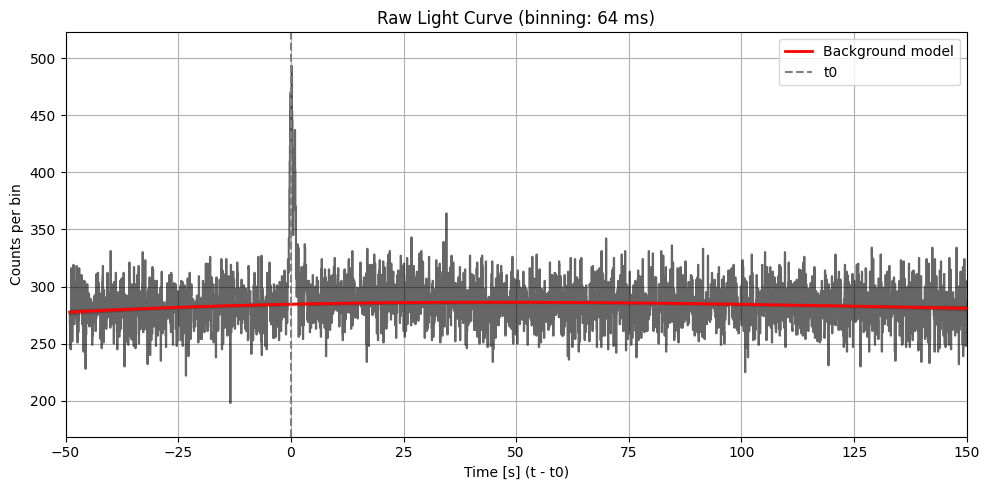

Max SNR: 7.474911389159172


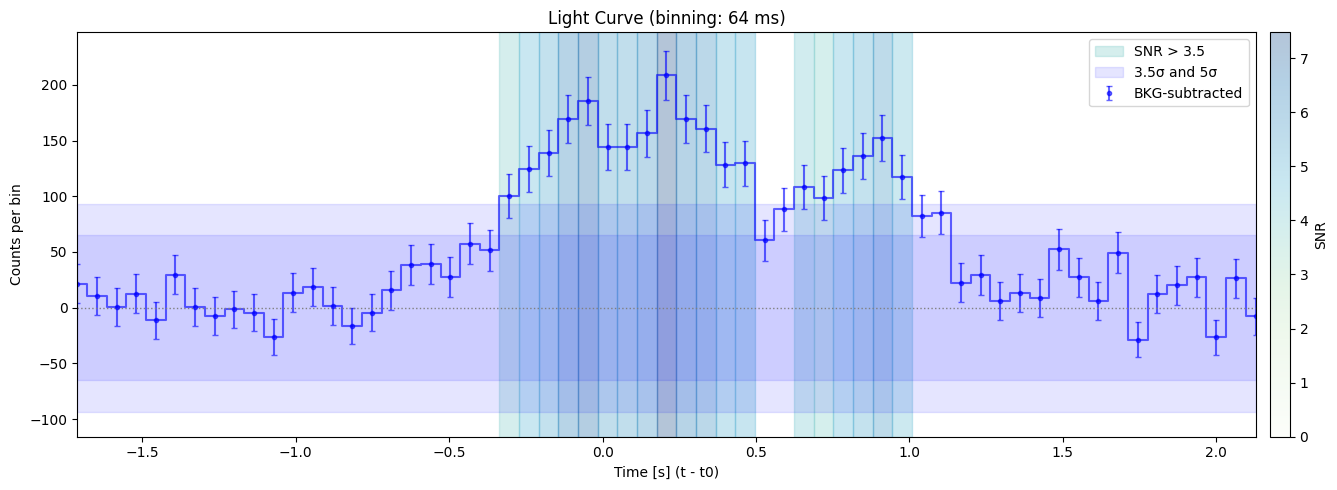

Bin size: 64 ms, Seed time: 0.20800817012786865, SNR: 7.474911389159172


MCMC sampling: 100%|██████████| 1000/1000 [00:01<00:00, 663.36it/s]


Best fit mcmc parameters: [ 8.60277131e-09 -3.72088249e-06  2.83410358e-04  1.00305922e+00]


<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

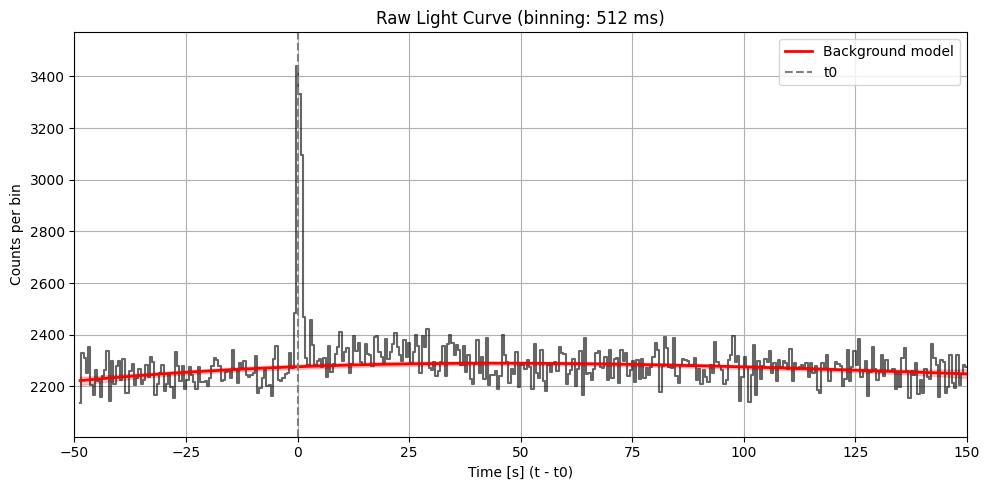

Max SNR: 15.390259838136728


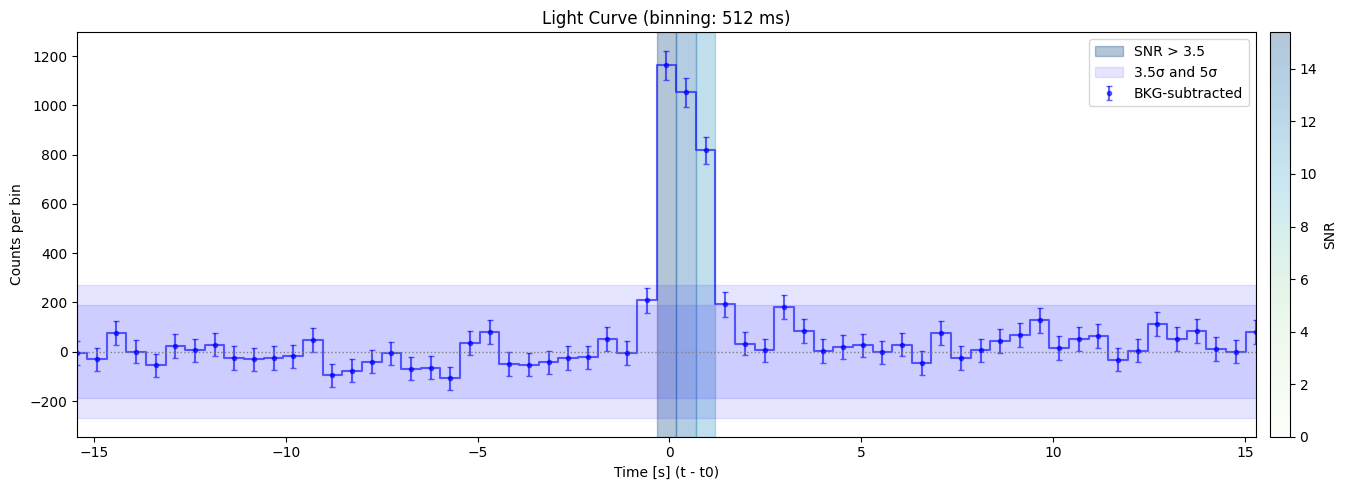

Bin size: 512 ms, Seed time: -0.08000338077545166, SNR: 15.390259838136728


MCMC sampling: 100%|██████████| 1000/1000 [00:01<00:00, 773.26it/s]


Best fit mcmc parameters: [ 1.04304029e-08 -4.05552801e-06  2.88254274e-04  1.00340674e+00]


<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

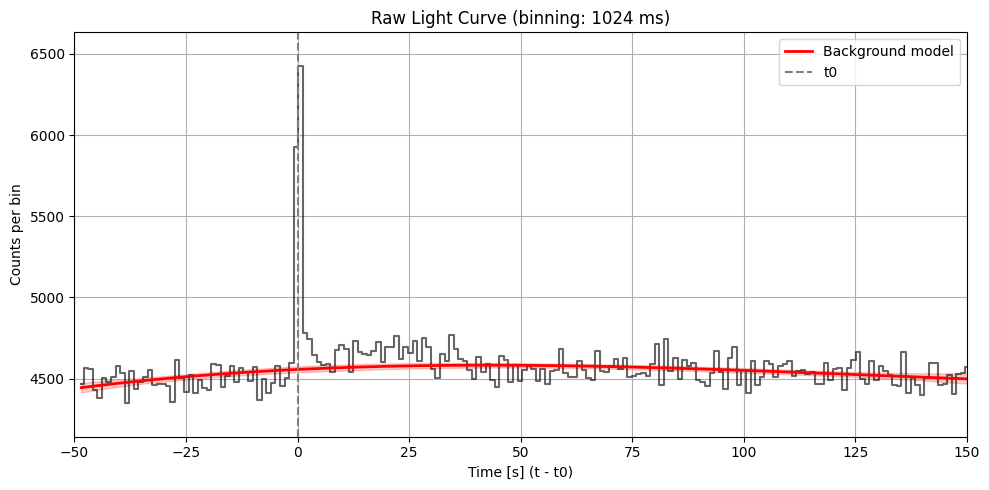

Max SNR: 17.82672006365474


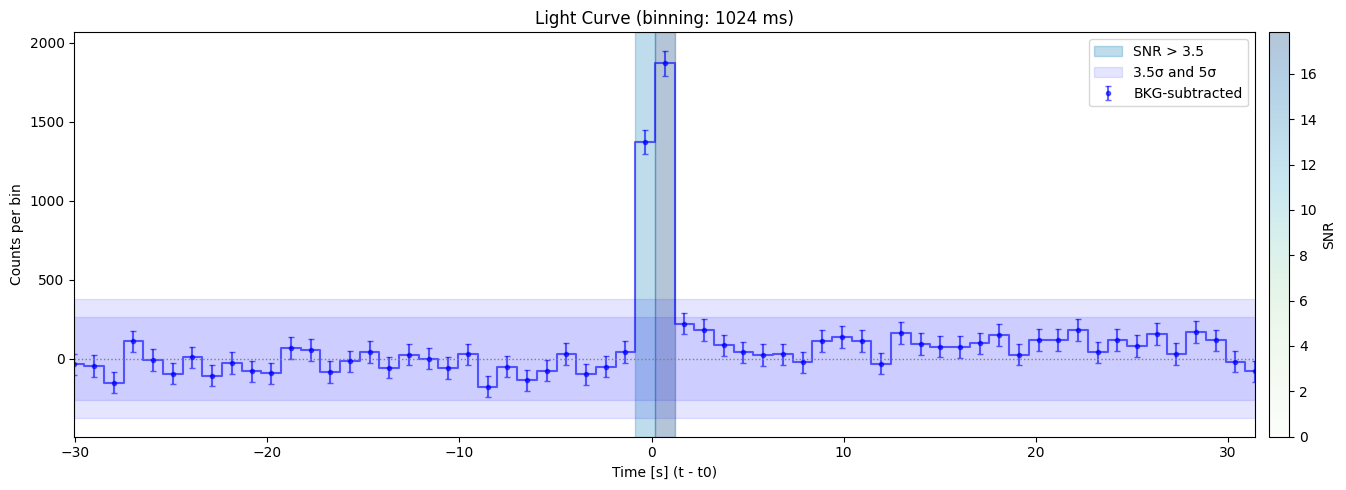

Bin size: 1024 ms, Seed time: 0.688002347946167, SNR: 17.82672006365474


MCMC sampling: 100%|██████████| 1000/1000 [00:01<00:00, 968.83it/s]


Best fit mcmc parameters: [ 1.78614674e-08 -5.43397999e-06  3.37843729e-04  1.00293172e+00]


<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

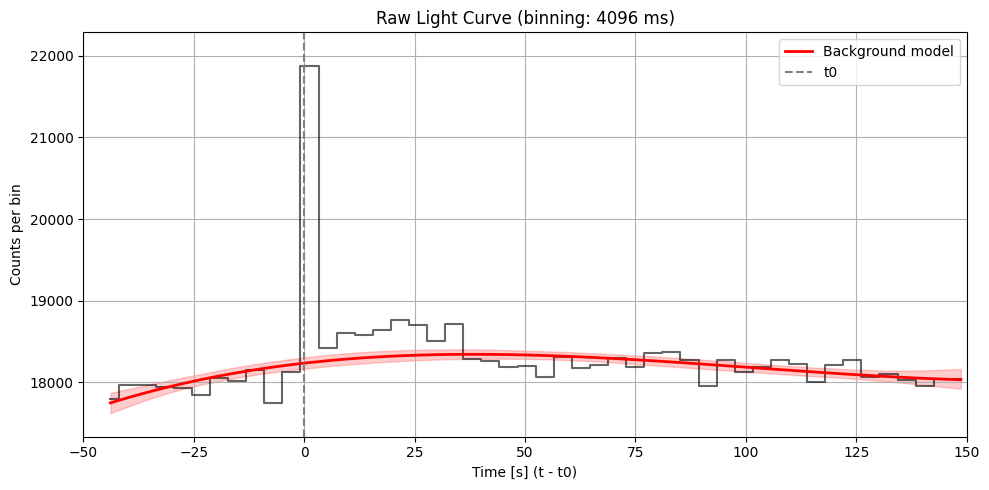

Max SNR: 18.136174223779157


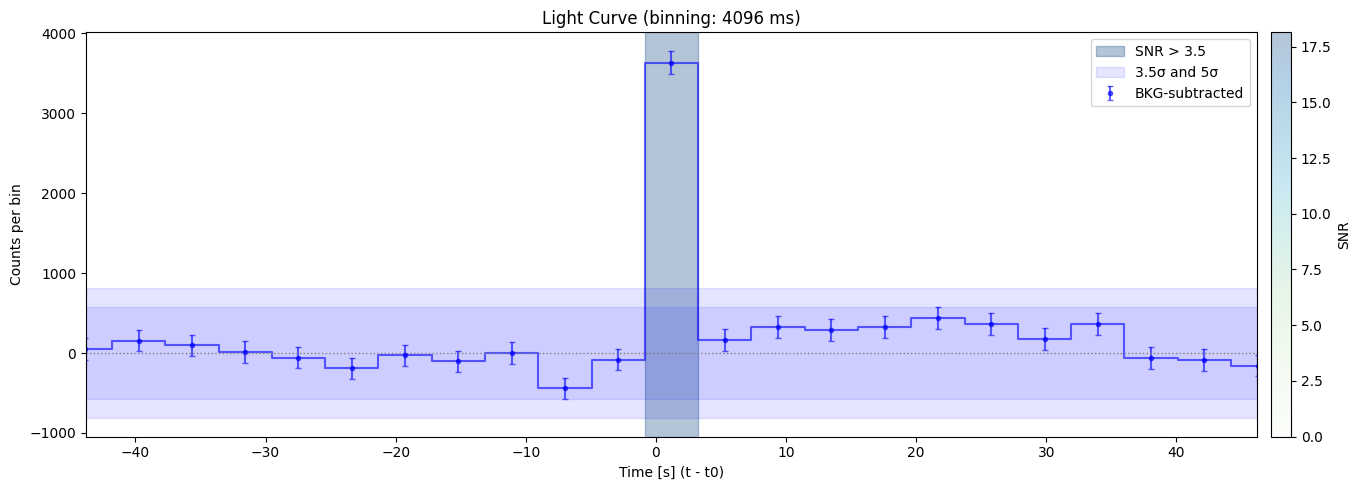

Bin size: 4096 ms, Seed time: 1.199999451637268, SNR: 18.136174223779157
Max SNR: 18.136174223779157 found at time 1.199999451637268 with duration 4096 ms


<Figure size 640x480 with 0 Axes>

In [230]:
cust_seeds(t0, workdir)

:::{note}
Try to see what happens if you load the unfiltered event data
:::

## Imaging

In [231]:
time_bins = [0, 4] * u.s
energybins = [15, 350] * u.keV

settled_skyview = event.create_skyview(timebins=time_bins, energybins=energybins, is_relative=True, T0=t0, input_dict=dict(aperture="CALDB:DETECTION"))

detected_sources = settled_skyview.detect_sources(input_dict=dict(signifmap=settled_skyview.snr_img_file,bkgvarmap=settled_skyview.bkg_stddev_img_file,clobber="yes", pcodethresh=0.01))


In [233]:
detected_sources

<QTable length=194>
CATNUM              NAME              ... BACKAPP ACOLAPP
                                      ...                
int16              str30              ...  int32   int32 
------ ------------------------------ ... ------- -------
    -1 UNKNOWN                        ...       0       1
   502 MRK 1501                       ...       0       1
  5418 SWIFT J0517.3+0134             ...       0       1
  5133 2MASX J23444387-4243124        ...       0       1
   219 ESO 297-018                    ...       0       1
  8008 IGR J03184-0014                ...       0       1
   487 PKS 2300-18                    ...       0       1
  5151 CGCG 459-058                   ...       0       1
   250 2MASX J04440903+2813003        ...       0       1
   ...                            ... ...     ...     ...
  5041 ESO 359- G 019                 ...       0       1
  5238 NGC 678                        ...       0       1
   542 NGC 1068                       ...       0       1
   590 SWIFT J0525.3-4600             ...       0       1
  5027 SWIFT J0040.3-0647             ...       0       1
   378 NGC 0612                       ...       0       1
  5106 2MASS J01053879-1416135        ...       0       1
  5253 SWIFT J0034.6-0422             ...       0       1
   867 MCG -07-48-021                 ...       0       1

This is just a function to read results

In [232]:
def log_imaging(detected_sources):
    # Print first 10 rows of detected_sources with selected columns if it's an astropy QTable
    try:
        # Prepare table header and rows with custom variable names to avoid conflicts
        # Print detected_sources as a nicely aligned table (first 10 rows)
        _table_header = "{:<3} {:<16} {:>10} {:>10} {:>8}  {:>9}".format(
            "Idx", "NAME", "RA", "DEC", "SNR", "PCODEFR"
        )
        _table_rows = []
        _ra_unknown = None
        _dec_unknown = None
        
        for _idx, _src in enumerate(detected_sources[:10]):
            _name = str(_src['NAME'])[:15]  # Truncate name if too long
            _ra = f"{_src['SKYCOORD'].ra.deg:10.3f}"
            _dec = f"{_src['SKYCOORD'].dec.deg:10.3f}"
            _snr = f"{_src['SNR']:8.3f}"
            _pcodefr = f"{_src['PCODEFR']:10.3f}"
            _table_rows.append(
                "{:<3} {:<16} {} {} {} {}".format(
                    _idx, _name, _ra, _dec, _snr, _pcodefr
                )
            )
 
            # Check if this is the UNKNOWN source
            if 'UNKNOWN' in str(_src['NAME']) :
                print("Found UNKNOWN source.")
                _ra_unknown = _src['SKYCOORD'].ra.deg
                _dec_unknown = _src['SKYCOORD'].dec.deg
        
        _table_str = "\n".join([_table_header] + _table_rows)
        logging.info("Detected sources (first 10):\n" + _table_str)
        
        return _ra_unknown, _dec_unknown
        
    except Exception as _exc:
        logging.error(f"Error printing detected_sources: {traceback.format_exc()}")
        return None, None

In [234]:
ra_source, dec_source = log_imaging(detected_sources)

2025-12-18 14:12:13,106 - INFO - Detected sources (first 10):
Idx NAME                     RA        DEC      SNR    PCODEFR
0   UNKNOWN              66.231    -49.760   10.821      0.193
1   MRK 1501              2.629     10.975    2.986      0.035
2   SWIFT J0517.3+0      79.335      1.054    2.539      0.555
3   2MASX J23444387     356.183    -42.720    1.988      0.332
4   ESO 297-018          24.655    -40.011    2.106      0.773
5   IGR J03184-0014      49.620     -0.256    2.438      0.922
6   PKS 2300-18         345.762    -18.690    1.831      0.124
7   CGCG 459-058         22.102     16.459    1.713      0.148
8   2MASX J04440903      71.038     28.217    1.788      0.022
9   2MASX J01064523      16.689      6.634    1.594      0.348


Found UNKNOWN source.


What happens if we create an image with a time interval much larger than GRB duration

In [235]:
time_bins = [-0.5, 1] * u.s
energybins = [15, 350] * u.keV

settled_skyview = event.create_skyview(timebins=time_bins, energybins=energybins, is_relative=True, T0=t0, input_dict=dict(aperture="CALDB:DETECTION"))

detected_sources = settled_skyview.detect_sources(input_dict=dict(signifmap=settled_skyview.snr_img_file,bkgvarmap=settled_skyview.bkg_stddev_img_file,clobber="yes", pcodethresh=0.01))

log_imaging(detected_sources)

2025-12-18 14:13:51,601 - INFO - Detected sources (first 10):
Idx NAME                     RA        DEC      SNR    PCODEFR
0   UNKNOWN              66.231    -49.754   14.652      0.193
1   MRK 1501              2.629     10.975    2.386      0.035
2   SWIFT J0336.8-2      54.200    -25.243    2.192      0.992
3   SWIFT J0245.2-0      41.300     -3.817    2.755      0.977
4   CGCG 468-002 NE      77.082     17.363    2.004      0.176
5   PKS 2300-18         345.762    -18.690    2.359      0.124
6   NGC 788              30.277     -6.815    2.016      0.922
7   XY Ari               44.037     19.441    2.044      0.277
8   Mrk 1018             31.567     -0.291    1.747      0.789
9   ESO 297-018          24.655    -40.011    1.602      0.773


Found UNKNOWN source.


(np.float64(66.23076195663347), np.float64(-49.75352693756179))

:::{note}
SNR is lower when you include more background in the image. The choice of the right time bin becomes relevant when the source is barely above the background level
:::

## Plotting 

In [209]:

from astropy.modeling.models import Gaussian1D

def map_imaging(ra_s, dec_s, workdir, skyview):

    fig = plt.figure()

    ax_zoom_rect = plt.axes([-1.2, 0.0, 0.9, 0.9],projection='astro degrees zoom',
                center=f'{ra_s}d {dec_s}d', radius='2 deg')
    
    ax_globe = plt.axes(
        [-0.3, -0.05, 1.25, 1.25],
        projection='astro degrees mollweide',
        )
    ax_hist = fig.add_axes([1.1, 0.2, 0.5, 0.8])  # [left, bottom, width, height]


    t = skyview.snr_img # loading the sky image already done outside

    hp_proj = t.healpix_projection(coordsys="icrs", nside=1024) # projecting in healpix (from detector coords to sky coords)

    '''
    The hp_proj object contains the healpix projection of the sky image.
    It is an array that contains [time, sky pixel, energy band]. 
    Since we created a single sky image for a single time bin and a single energy band,
    we can extract the first time and first energy band to get the sky map.
    '''

    snr_map = hp_proj.contents[0,:,0]
    ax_zoom_rect.imshow_hpx((snr_map, 'ICRS'),  cmap="magma", alpha=1.0, zorder=1)

    '''
    We load again the partial coding image to overplot the contours
    '''

    plot_quantity_pc = skyview.pcode_img.healpix_projection(coordsys="icrs", nside=1024).contents[0,:,0]

    cs = ax_globe.contour_hpx((plot_quantity_pc, 'ICRS'), nested=False, colors='red', levels=[0.01,0.3,0.8], linewidths=1, zorder=2)

    '''
    We finally create the histogram of the SNR values
    '''

    h = skyview.snr_img.contents.flatten()
    val, _, _=plt.hist(h, bins=100, alpha=0.8, color='blue', label='SNR histogram', histtype='step')
    
    max_snr_value = np.nanmax(h)
    min_snr_value = np.nanmin(h)
    ax_hist.axvline(max_snr_value, color='red', linestyle='--', label=f'Max SNR: {max_snr_value:.2f}')

    g = Gaussian1D(amplitude=val.max(), stddev=1)
    x = np.arange(-30, 30, .01)
    ax_hist.plot(x, g(x), 'k-')

    # Here some aestethic adjustments

    ax_zoom_rect.coords[0].set_major_formatter('d.d')  # 3 decimal degrees
    ax_zoom_rect.coords[1].set_major_formatter('d.d')  # 3 decimal degrees
    ax_zoom_rect.grid()
    vmin= np.nanmin(snr_map)
    vmax=np.nanmax(snr_map)
    cmap_custom = plt.cm.inferno
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm)
    cbar = plt.colorbar(sm, ax=ax_zoom_rect, shrink=0.5, orientation='horizontal', aspect=30, pad=0.15)
    cbar.mappable.set_clim(vmin=vmin,vmax=vmax)
    cbar.set_label('SNR')

    ax_globe.grid()
    ax_globe.mark_inset_axes(ax_zoom_rect)
    ax_globe.connect_inset_axes(ax_zoom_rect, 'upper right')
    ax_globe.connect_inset_axes(ax_zoom_rect, 'lower right')


    ax_hist.set_xlabel('')
    ax_hist.set_ylabel('Counts')
    ax_hist.set_ylabel('SNR')
    ax_hist.set_yscale('log')
    ax_hist.yaxis.tick_right()
    ax_hist.yaxis.set_label_position("right")
    ax_hist.set_ylim([0.1,2*val.max()])
    ax_hist.set_xlim([min_snr_value-1,max_snr_value+1])
    ax_hist.legend(
        loc='upper right')
    
    # If we want to implement at some point the ext localization
    fit_file = next((fname for fname in os.listdir(workdir) if 'ext_loc' in fname), None)
    if fit_file:
        loc_handles = map_ext(fit_file, workdir, ax_globe)        
        leg_ext = ax_globe.legend(handles=loc_handles, loc='lower left', frameon=True, bbox_to_anchor=(-0.1, -0.15), borderaxespad=0.5)
        ax_globe.add_artist(leg_ext)

    ax_globe.clabel(cs, inline=True, fmt='%1.2f', fontsize=8)
    red_line = [Line2D([0], [0], color='red', lw=1, label='Partial coding')]

    ax_leg_bot = fig.add_axes([0.76, 0.15, 0.22, 0.28])
    ax_leg_bot.axis('off')

    fov_legend = ax_leg_bot.legend(handles=red_line, loc='lower left', frameon=True, borderaxespad=0.5)
    ax_leg_bot.add_artist(fov_legend)

    plt.savefig(os.path.join(workdir,'map_imaging.png'), bbox_inches='tight', dpi=300)

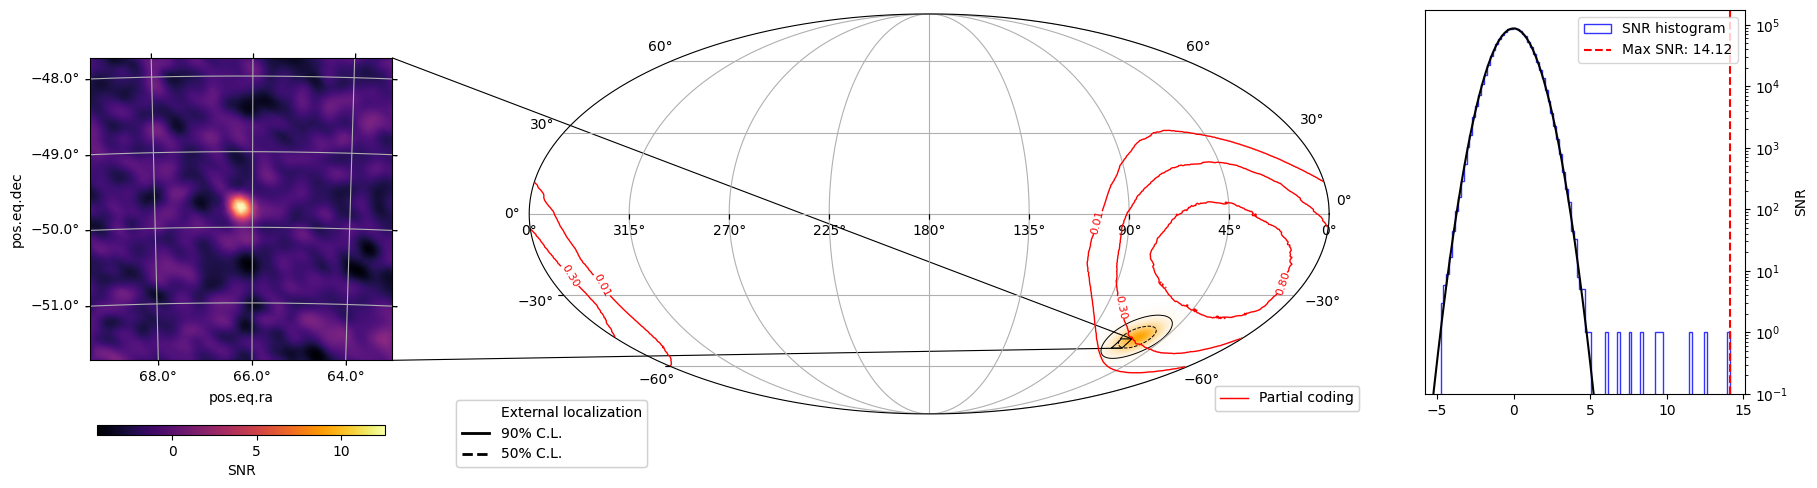

In [210]:
map_imaging(ra_source, dec_source, workdir, settled_skyview)

## Looking at the DPI

In [211]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_dpi(self, mask_value = None, emin=None, emax=None, tmin=None, tmax=None, plot_rate=False):
        """
        This method allows the user to conveniently plot the histogram for a single energy bin and time interval.
        Any detectors with 0 counts (due to detectors being off or due to there being no detectors in the specified
        DETX and DETY coordinates) are blacked out.

        By default, the histogram is binned along the energy and time axes. This behavior can be changed by specifying
        emin/emax and/or tmin/tmax. These values should all exist in the ebins and tbins attributes.

        :param emin: None or an astropy Quantity array of the beginning of the energy bins
        :param emax: None or an astropy Quantity array of the end of the energy bins
        :param tmin: None or an astropy Quantity array of the starting time bin edges that the histogram will be
            rebinned into
        :param tmax: None or an astropy Quantity array of the end time bin edges that the histogram will be
            rebinned into
        :param plot_rate: Boolean to denote if the count rate should be plotted. The histogram gets divided by the
            exposure time of the plotted histogram
        :return: matplotlib figure and axis for the plotted histogram
        """

        if emin is None and emax is None:
            plot_emin = self.ebins["E_MIN"].min()
            plot_emax = self.ebins["E_MAX"].max()
        elif emin is not None and emax is not None:
            plot_emin = emin
            plot_emax = emax
        else:
            raise ValueError(
                "emin and emax must either both be None or both be specified."
            )
        plot_e_idx = np.where(
            (self.ebins["E_MIN"] >= plot_emin) & (self.ebins["E_MAX"] <= plot_emax)
        )[0]

        if tmin is None and tmax is None:
            plot_tmin = self.tbins["TIME_START"].min()
            plot_tmax = self.tbins["TIME_STOP"].max()
        elif tmin is not None and tmax is not None:
            plot_tmin = tmin
            plot_tmax = tmax
        else:
            raise ValueError(
                "tmin and tmax must either both be None or both be specified."
            )
        plot_t_idx = np.where(
            (self.tbins["TIME_START"] >= plot_tmin)
            & (self.tbins["TIME_STOP"] <= plot_tmax)
        )[0]

        # now start to accumulate the DPH counts based on the time and energy range that we care about
        plot_data = self.contents[plot_t_idx, :, :, :]

        if len(plot_t_idx) > 0:
            plot_data = plot_data.sum(axis=0)
        else:
            raise ValueError(
                f"There are no DPH time bins that fall between {plot_tmin} and {plot_tmax}"
            )

        plot_data = plot_data[:, :, plot_e_idx]

        if len(plot_e_idx) > 0:
            plot_data = plot_data.sum(axis=-1)
        else:
            raise ValueError(
                f"There are no DPH energy bins that fall between {plot_emin} and {plot_emax}"
            )

        if plot_rate:
            # calculate the total exposure
            exposure_tot = np.sum(self.exposure[plot_t_idx])
            plot_data /= exposure_tot

        # set any 0 count detectors to nan so they get plotted in black
        # this includes detectors that are off and "space holders" between detectors where the value is 0
        plot_data[plot_data == 0] = np.nan
        
        mask = (plot_data.value < mask_value[0]) | (plot_data.value > mask_value[1])
        plot_data[mask] = np.nan

        data = plot_data.flatten()
        data = data[data != 0]
        data = data.value

        # Create the figure with two subplots: main image and histogram
        fig, (ax, ax_hist) = plt.subplots(
            1, 2,
            figsize=(12, 5),  # wider figure
            gridspec_kw={'width_ratios': [4, 2]}  # more space for histogram
        )

        # Main image panel
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cmap = plt.colormaps.get_cmap("viridis")
        cmap.set_bad(color="k")

        im = ax.imshow(plot_data.value, origin="lower", interpolation="none", cmap=cmap)
        fig.colorbar(im, cax=cax, orientation="vertical", label=plot_data.unit)

        ax.set_ylabel("DETY")
        ax.set_xlabel("DETX")

        # Histogram panel
        # Compute bin edges so that bins are centered at 1, 2, 3, ... (integers)
        min_center = 0
        max_center = int(np.ceil(np.nanmax(data)))
        bin_centers = np.arange(min_center, max_center + 1)
        bins = bin_centers - 0.5
        bins = np.append(bins, bins[-1] + 1)
        ax_hist.hist(data, bins=bins, color="gray", histtype="step", edgecolor="black", label="Counts")
        ax_hist.set_xlabel("Counts per detector")
        ax_hist.set_yscale("log")
        ax_hist.grid(True)
        mean_val = np.nanmean(data)
        ax_hist.axvline(mean_val, color="red", linestyle="--", label="Mean = {:.2f}".format(mean_val))
        ax_hist.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.8])  # Make space for suptitle

        return fig, ax

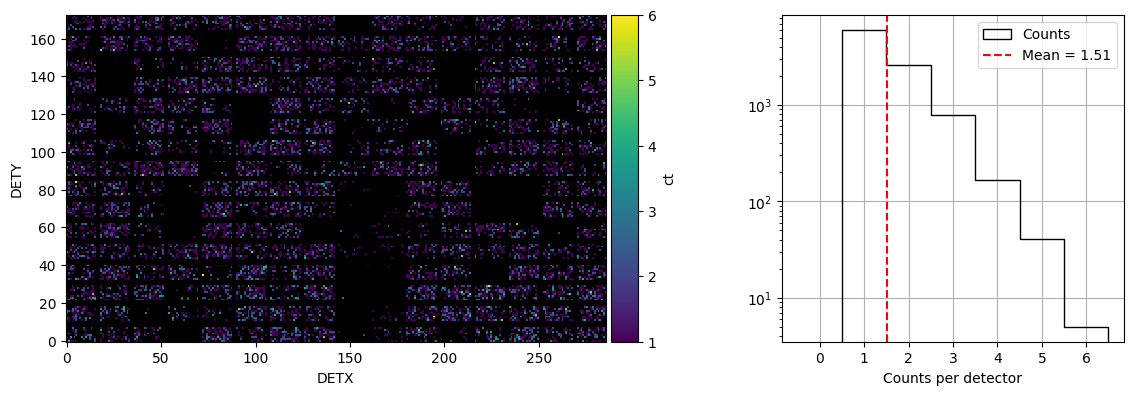

<Figure size 640x480 with 0 Axes>

In [212]:
time_bins=[0,3]*u.s
energybins = [15, 350] * u.keV

event_dpi=event.create_dpi(timebins=time_bins, energybins=energybins, T0=t0, is_relative = True)

f = plot_dpi(event.dpis[-1], mask_value = [0, np.inf])
plt.show()
plt.savefig(os.path.join(workdir, 'dpi.png'), dpi=300, bbox_inches='tight')

2025-12-18 12:23:41,287 - INFO - Plotting DPI plot for time bins [10. 13.] s


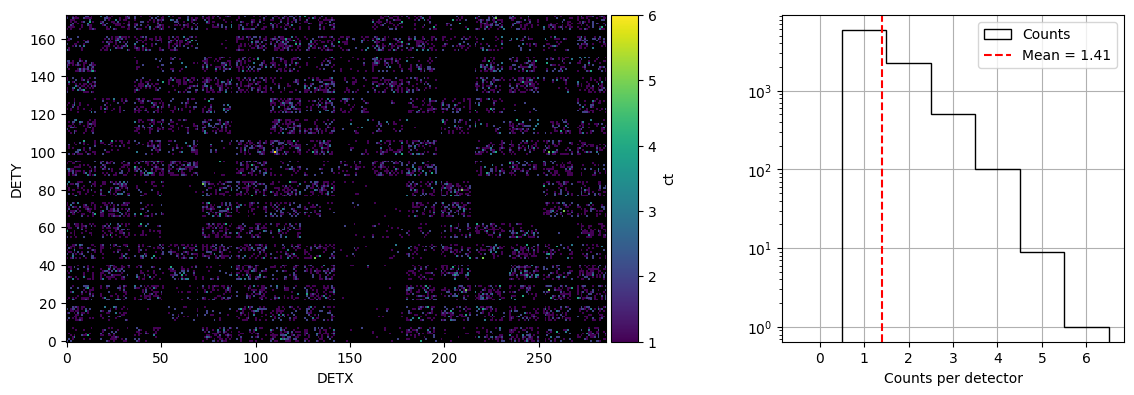

In [213]:
time_bins=[10,13]*u.s
logging.info(f'Plotting DPI plot for time bins {time_bins}')
energybins = [15, 350] * u.keV
event_dpi=event.create_dpi(timebins=time_bins, energybins=energybins, T0=t0, is_relative = True)
f = plot_dpi(event.dpis[-1], mask_value = [0, np.inf])
plt.show()

## Light curve after applying mask weighting

In [214]:
event.apply_mask_weighting(ra=ra_source*u.deg, dec=dec_source*u.deg)

Under the hood apply_mask_weighting does the following
```
input_dict = dict(
    infile=str(self.event_files),
    attitude=str(self.attitude_file),
    detmask=str(self.detector_quality_file),
    ra=ra.value,
    dec=dec.value,
    auxfile=str(temp_auxil_raytracing_file),
    clobber="YES",
)
batmaskwtevt_return = self._call_batmaskwtevt(input_dict)
```

In [215]:

def plot_lc(event, t0, deltat, workdir, pipe):

    lc = event.create_lightcurve(energybins=[15, 50, 100, 350] * u.keV) # By default the mask weighting is applied

    color = ['red','blue', 'green', 'black']
    label = ['15-50 keV', '50-100 keV', '100-350 keV', '15-350 keV']
    bin_sizes = [0.064, 0.256, 1.024]  # in seconds

    fig, axes = plt.subplots(len(bin_sizes), 1, figsize=(10, 5 * len(bin_sizes)), sharex=True)

    for i, bin_size in enumerate(bin_sizes):
        ax = axes[i]
        lc.set_timebins(
                    timebinalg="uniform",
                    timedelta=np.timedelta64(int(bin_size*1000), 'ms'),
                    tmin=-5*deltat*u.s,
                    tmax=10*deltat*u.s,
                    T0=t0,
                    is_relative = True)
        lc.set_energybins(energybins=[15, 50, 100, 350]* u.keV)
        # Now plot each sub-band
        for n in range(0,4):
            time = lc.data['TIME'][:].value
            counts = lc.data['RATE'][:,n].value
            errors = lc.data['ERROR'][:,n].value
            if n==3:
                ax.errorbar(time-t0, counts, yerr=errors, color=color[n], ls='', zorder=n, alpha=1.0)
                ax.step(time-t0, counts, where='mid', color=color[n], label=label[n], zorder=n, alpha=1.0)
            else:
                ax.step(time-t0, counts, where='mid', color=color[n], label=label[n], zorder=n, alpha=0.4)
        ax.set_title(f"Light Curve (bin size: {bin_size:.3f} s)")
        ax.axhline(y=0.0, color='r', linestyle='--', linewidth=1)
        ax.set_ylabel("Counts/bin")
        ax.legend()


    axes[-1].set_xlabel("Time [s] (t - t0)")
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(workdir, f'lc_{pipe}.png'), dpi=300)
    plt.close()


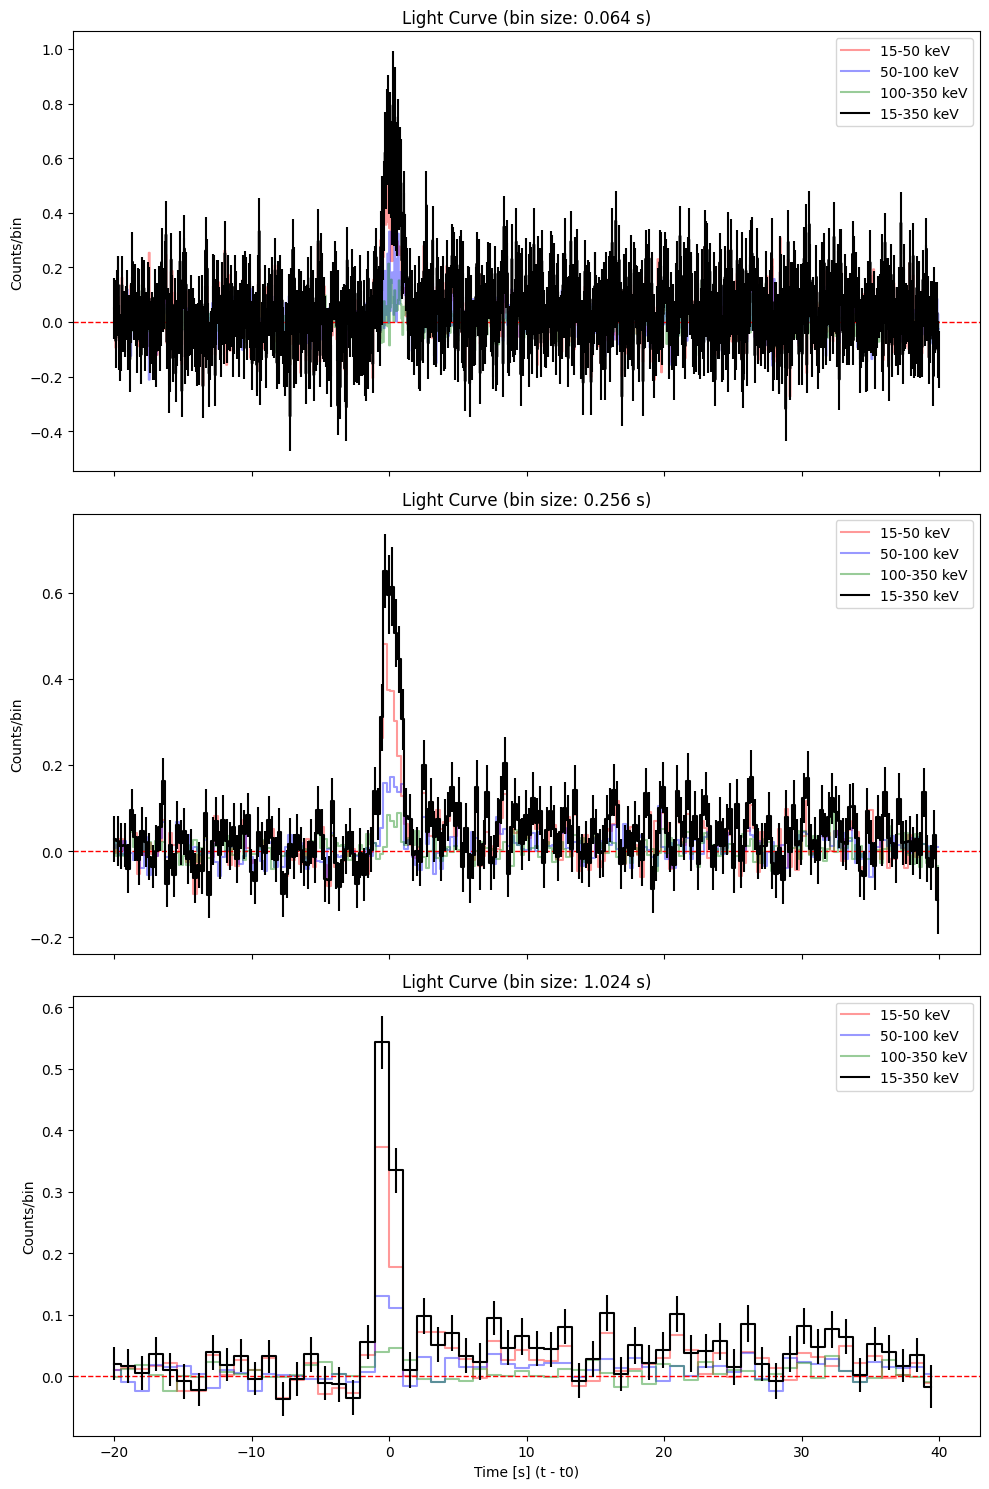

In [216]:
delta_t = 4  # typical duration in seconds of the event
plot_lc(event, t0, delta_t, workdir, 'imaging')

## Bayesian blocks light curve

Text(0.5, 1.0, 'Bayesian Block Light Curve')

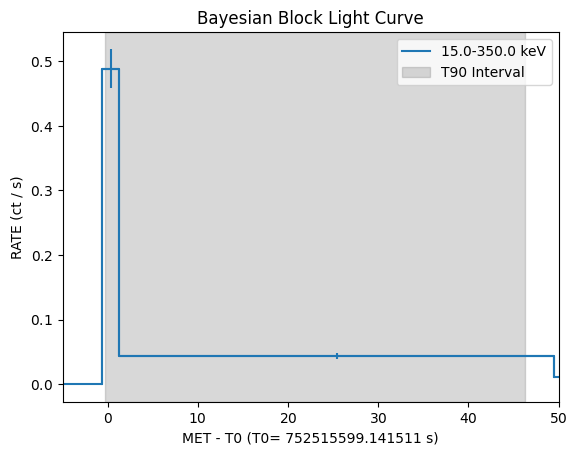

In [236]:
lc=event.create_lightcurve(energybins=[15, 350] * u.keV, recalc=True)

lc.set_timebins(timebinalg="bayesian", save_durations=True)

bayesian_tstart = lc.tbins["TIME_START"]
bayesian_tstop = lc.tbins["TIME_STOP"]
t90_start = lc.tdurs['T90']['TSTART']
t90_stop = lc.tdurs['T90']['TSTOP']
mask = (bayesian_tstop >= t90_start) & (bayesian_tstart <= t90_stop)

lc.plot(T0=t0, plot_relative=True)

# Highlight T90 interval
plt.axvspan(t90_start.value - t0, t90_stop.value - t0, color='gray', alpha=0.3, label='T90 Interval')
plt.legend()
plt.xlim(-5, 50)
plt.title("Bayesian Block Light Curve")

In [237]:
print(f"The t_90 duration is {lc.tdurs['T90']['TSTOP'] - lc.tdurs['T90']['TSTART']:.2f}")
print(f"Emission start time: {lc.tdurs['T90']['TSTART'].value - t0:.2f} seconds relative to t0")
print(f"Emission stop time: {lc.tdurs['T90']['TSTOP'].value - t0:.2f} seconds relative to t0")

The t_90 duration is 46.59 s
Emission start time: -0.26 seconds relative to t0
Emission stop time: 46.33 seconds relative to t0


We just discovered that, even if the burst looks short, there is a long tail, also known as extended emission

https://academic.oup.com/mnras/article/544/1/548/8256866

Here I just copied and pasted the _call_battblocks from BatAnalysis, trying to edit by hand some setup variables of the 'battblocks'

In [219]:
try:
    import heasoftpy.swift as hsp
    import heasoftpy as hsp_core
except ModuleNotFoundError as err:
    # Error handling
    print(err)

def _call_battblocks_my(self, output_file=None, save_durations=True):
    """
    This method calls battblocks for bayesian blocks binning of a lightcurve. This rebins the lightcurve into a 64 ms
    energy integrated energy bin (based on current ebins) to calculate the bayesian block time bins and then
    restores the lightcurve back to the prior energy binning.

    :param output_file: Path object of the file that will be created by battblocks with the good time intervals of
        interest
    :param save_durations: Boolean determining if battblocks should calculate durations such as T90, T50, background
        durations, etc and save those to a file. This file, if created, will be read in and saved to the tdurs attribute.
        This file will be saved to the gti subdirectory of the event results directory.
    :return: output_file Path object, HEASoftpy results object from battblocks call
    """

    if len(self.ebins["INDEX"]) > 1:
        recalc_energy = True
        # need to rebin to a single energy and save current energy bins
        old_ebins = self.ebins.copy()
        # see if we have the enrgy integrated bin included in the arrays:
        if (self.ebins["E_MIN"][0] == self.ebins["E_MIN"][-1]) and (
                self.ebins["E_MAX"][-2] == self.ebins["E_MAX"][-1]):
            self.set_energybins(emin=self.ebins["E_MIN"][-1], emax=self.ebins["E_MAX"][-1])
            calc_energy_integrated = True  # this is for recalculating the lightcurve later in the method
        else:
            self.set_energybins(emin=self.ebins["E_MIN"][0], emax=self.ebins["E_MAX"][-1])
            calc_energy_integrated = False
    else:
        recalc_energy = False

    # set the time binning to be 64 ms. This time binning will be over written anyways so dont need to restore anything
    self.set_timebins()

    # get the set of default values which we will modify
    # stop
    test = hsp_core.HSPTask('battblocks')
    input_dict = test.default_params.copy()

    if output_file is None:
        # use the same filename as for the lightcurve file but replace suffix with gti and put it in gti subdir instead of lc
        new_path = self.lightcurve_file.parts
        new_name = self.lightcurve_file.name.replace("lc", "gti")

        output_file = Path(*new_path[:self.lightcurve_file.parts.index('lc')]).joinpath("gti").joinpath(new_name)

    # modify some of the inputs here
    input_dict["infile"] = str(
        self.lightcurve_file)  # this should ideally be a 64 ms lightcurve of a single energy bin
    input_dict["outfile"] = str(output_file)

    # these are used by batgrbproducts:
    input_dict["bkgsub"] = "YES"
    input_dict["clobber"] = "YES"
    input_dict["tlookback"] = 10
    # input_dict["nspill"] = 256
    # input_dict["(tpeak"] = 0.01
    # input_dict["(ncp prior"] = 2
    input_dict["(coalescefrac"] = 0.0
    if save_durations:
        dur_output_file = output_file.parent / output_file.name.replace("gti", "dur")
        input_dict["durfile"] = str(dur_output_file)

    try:
        battblocks_return = hsp.battblocks(**input_dict)

    except Exception as e:
        print(e)
        raise RuntimeError(f"The call to Heasoft battblocks failed with inputs {input_dict}.")

    # reset the energy bins to what they were before
    if recalc_energy:
        if calc_energy_integrated:
            min_ebins = old_ebins["E_MIN"][:-1]
            max_ebins = old_ebins["E_MAX"][:-1]
        else:
            min_ebins = old_ebins["E_MIN"]
            max_ebins = old_ebins["E_MAX"]

        self.set_energybins(emin=min_ebins, emax=max_ebins,
                            calc_energy_integrated=calc_energy_integrated)

    if battblocks_return.returncode != 0:
        raise RuntimeError(f'The call to Heasoft battblocks failed with message: {battblocks_return.output}')

    if save_durations:
        self._parse_durations(dur_output_file)

    return output_file, battblocks_return


In [220]:
_call_battblocks_my(lc)

(PosixPath('/Users/sjs8171/Desktop/bat_glimpse/data/00018897003_eventresult/gti/t_uniform_dt_0.064_1chan.gti'),
 ---------------------
 :: Execution Result ::
 ---------------------
 > Return Code: 0
 > Output:
 ******************************************
          battblocks v1.18
 ------------------------------------------
      Input Data: /Users/sjs8171/Desktop/bat_glimpse/data/00018897003_eventresult/lc/t_uniform_dt_0.064_1chan.lc
      Output GTI: /Users/sjs8171/Desktop/bat_glimpse/data/00018897003_eventresult/gti/t_uniform_dt_0.064_1chan.gti
  Events to Skip: 128     Changepoint log(prob) Prior: 6.000000
   Internal Tick: 1.000000e-04 s
   Lookback time: 10 s
  Bkg. Subtract?: yes (for fluence/T50/T90 calculations)
 ------------------------------------------
   Estimated T90 duration: 46.592 s +/- 10.2472 s
   Estimated T50 duration: 25.728 s +/- 6.54335 s
   Estimated Peak Interval: MET   752515599.48799992 +/- 0.500000 s
   Estimated background rate 1:        0.001 near MET 752

In [221]:
print(f"The t_90 duration is {lc.tdurs['T90']['TSTOP'] - lc.tdurs['T90']['TSTART']:.2f}")
print(f"Emission start time: {lc.tdurs['T90']['TSTART'].value - t0:.2f} seconds relative to t0")
print(f"Emission stop time: {lc.tdurs['T90']['TSTOP'].value - t0:.2f} seconds relative to t0")

The t_90 duration is 46.59 s
Emission start time: -0.26 seconds relative to t0
Emission stop time: 46.33 seconds relative to t0


## Spectrum during the $t_{90}$ interval

We are going to create here the spectrum. We just need to select the time interval

In [238]:
spectrum_t90=event.create_pha(tstart=lc.tdurs['T90']['TSTART'],
                               tstop=lc.tdurs['T90']['TSTOP'],
                                recalc=True)

Once we have the spectrum, we can also fit. The 'fit_spectrum' function calls XSPEC and save the results


1 spectrum  in use
 
Spectral Data File: t_752515598.88-752515645.4719999_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.661e-02 +/- 4.842e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 46.59 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_752515598.88-752515645.4719999_80chan.rsp for Source 1


Fit statistic  : Chi-Squared                   55.93     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                   55.93     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 9.72e-01 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Val

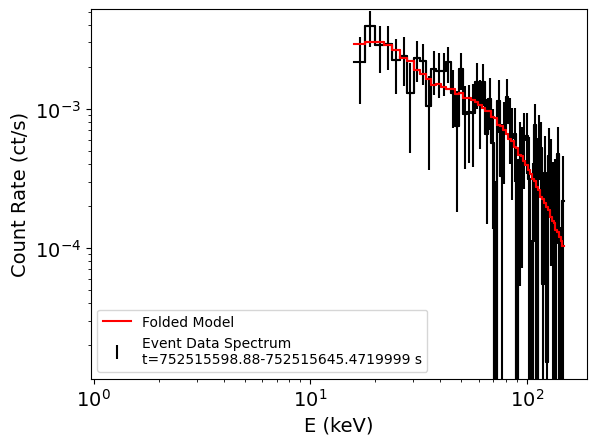

In [239]:
ba.fit_spectrum(spectrum_t90, generic_model="cflux*po", # simple power-law with flux normalization
                setPars={1:"15,-1", 2:"150,-1",3:-9, 4:"-1",5:".001,-1"},
                use_cstat=False, fit_iterations=10000)

We can access the results which are saved in the form of a dictionary

In [240]:
params = spectrum_t90.spectral_model['parameters']
lg10_flux = params['lg10Flux']
flux = 10 ** lg10_flux['val']
flux_lo = 10 ** lg10_flux['lolim']
flux_hi = 10 ** lg10_flux['hilim']

print(f"Converted flux: best fit = {flux:.3e}, interval = ({flux_lo:.3e}, {flux_hi:.3e})")
# photon index
photon_index = params['PhoIndex']['val']
photon_index_lo = params['PhoIndex']['lolim']
photon_index_hi = params['PhoIndex']['hilim']

print(f"Photon index: best fit = {photon_index:.3f}, interval = ({photon_index_lo:.3f}, {photon_index_hi:.3f})")

Converted flux: best fit = 3.831e-08, interval = (3.332e-08, 4.333e-08)
Photon index: best fit = 1.427, interval = (1.210, 1.645)


## Time resolved spectra using Bayesian blocks

We can also repeat the spectral fit but done for each temporal bin we define. In this case we are using the bayesian blocks output, but we can use any time bin, defining start and stop times of them

In [225]:
bayesian_spectra = event.create_pha(
    tstart=bayesian_tstart[mask],
    tstop=bayesian_tstop[mask],
    recalc=True)

In [241]:
bayesian_tstop[mask]

<Quantity [7.52515600e+08, 7.52515649e+08] s>

For the fit here we can also use multiple CPUs, if available. Since we are inside a jupyter notebook, we need to to that in a 'parallel_backend'. If you run it outside jupyter, there is no need for that.

In [242]:
import os
from joblib import parallel_backend

joblib_tmp = os.path.join(workdir, "joblib_tmp")
os.makedirs(joblib_tmp, exist_ok=True)
os.environ["JOBLIB_TEMP_FOLDER"] = joblib_tmp

n_procs = min(len(bayesian_spectra), multiprocessing.cpu_count())

with parallel_backend(
    'loky',
    n_jobs=n_procs,
    max_nbytes=None,             
    inner_max_num_threads=1,      
    temp_folder=joblib_tmp
):
    output_bayesian_spectra = ba.parallel.batspectrum_TTE_analysis(
        bayesian_spectra,
        generic_model="cflux*po",
        setPars={1:"15,-1", 2:"150,-1", 3:-9, 4:"-1", 5:".001,-1"},
        nprocs=n_procs,
        use_cstat=False,
        fit_iterations=10000,
        recalc=True
    )


1 spectrum  in use
 
Spectral Data File: t_752515600.416-752515648.672_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.168e-02 +/- 4.927e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 48.26 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_752515600.416-752515648.672_80chan.rsp for Source 1


Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      15.0000      frozen
   2    1   cflux      Emax       keV      150.000      frozen
   3    1   cflux      lg10Flux   cgs      -9.00000     +/-  0.0          
   4    2   powerlaw   PhoIndex            -1.00000     +/-  0.0          
   5    2   powerlaw   norm                1.00000E-03  frozen
________________________________________________________________________


Fit statistic  : Chi-Squared                  

We finally concatenate spectra

In [243]:
from batanalysis.batlib import concatenate_spectrum_data

spect_data = concatenate_spectrum_data(output_bayesian_spectra, ["flux", "phoindex"])

and plot 

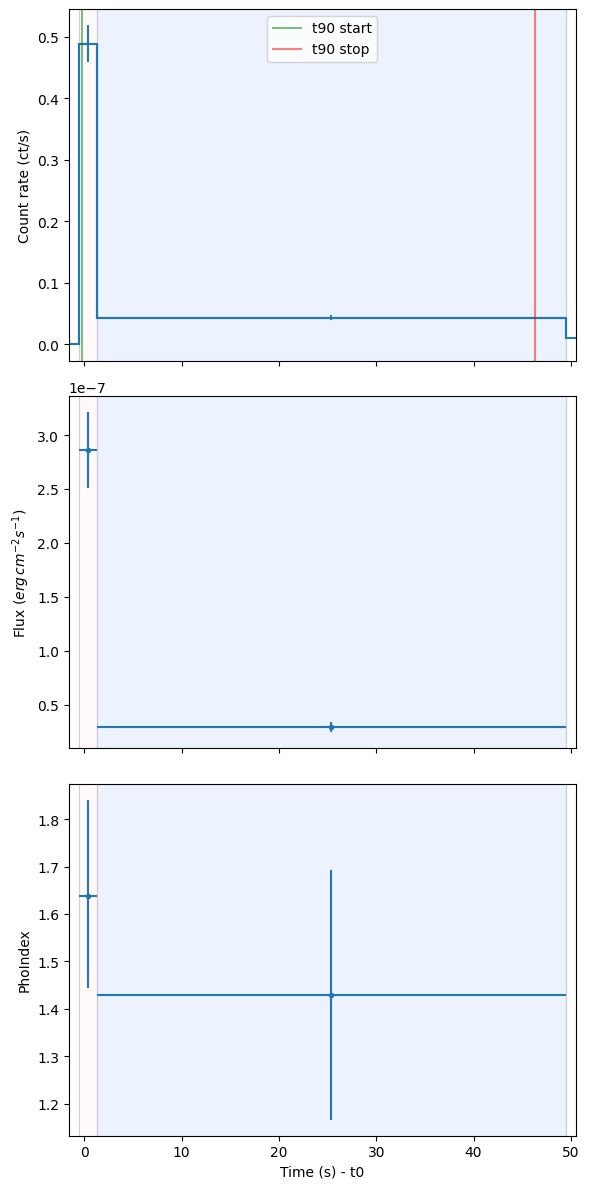

In [244]:
fig, axes = plt.subplots(3, sharex=True, figsize=(6, 12))

start_times = lc.tbins["TIME_START"]-t0*u.s
end_times = lc.tbins["TIME_STOP"]-t0*u.s
mid_times = lc.tbins["TIME_CENT"]-t0*u.s

bin_start_rel = (spect_data["TIME_START"] - t0 * u.s).to_value(u.s)
bin_stop_rel = (spect_data["TIME_STOP"] - t0 * u.s).to_value(u.s)
bin_colors = ["#ffe9e9", "#b7cefc"]
for idx, (start, stop) in enumerate(zip(bin_start_rel, bin_stop_rel)):
    color = bin_colors[idx % len(bin_colors)]
    for ax in axes:
        ax.axvspan(start, stop, color=color, alpha=0.25, zorder=0)

edges_rel = np.unique(np.concatenate([bin_start_rel, [bin_stop_rel[-1]]]))
for edge in edges_rel:
    for ax in axes:
        ax.axvline(edge, color="0.75", linewidth=0.8, alpha=0.7, zorder=1)

rate = lc.data['RATE']
rate_error = lc.data["ERROR"]
        
line = axes[0].plot(start_times, rate, ds='steps-post')
line_handle, = axes[0].plot(end_times, rate, ds='steps-pre', color=line[-1].get_color())

flux = spect_data['flux']
flux_lolim = spect_data['flux_lolim']
flux_hilim = spect_data['flux_hilim']

axes[0].errorbar(mid_times, rate, yerr=rate_error, ls='None', color=line[-1].get_color())
axes[0].set_ylabel('Count rate (ct/s)')

axes[0].axvline(lc.tdurs['T90']['TSTART'].value-t0, color='green', alpha=0.5, label="t90 start")
axes[0].axvline(lc.tdurs['T90']['TSTOP'].value-t0, color='red', alpha=0.5, label="t90 stop")

axes[0].legend()

spec_param = 'flux'

y = spect_data[spec_param]

# get the errors
lolim = spect_data[f"{spec_param}_lolim"]
hilim = spect_data[f"{spec_param}_hilim"]

yerr = np.array([lolim, hilim])
y_upperlim = spect_data[f"{spec_param}_upperlim"]

# find where we have upper limits and set the error to 1 since the nan error value isnt
# compatible with upperlimits
yerr[:, y_upperlim] = 0.2 * y[y_upperlim]

tbin_cent = 0.5 * (spect_data["TIME_START"] + spect_data["TIME_STOP"])
tbin_err = 0.5 * (spect_data["TIME_STOP"] - spect_data["TIME_START"])

axes[1].errorbar(
    tbin_cent-t0*u.s,
    y,
    xerr=tbin_err,
    yerr=yerr,
    uplims=y_upperlim,
    linestyle="None",
    marker="o",
    markersize=3,
    zorder=3,
)  # color="red"

axes[1].set_ylabel('Flux ($erg \, cm^{-2} s^{-1}$)')

spec_param = 'phoindex'

y = spect_data[spec_param]

# get the errors
lolim = spect_data[f"{spec_param}_lolim"]
hilim = spect_data[f"{spec_param}_hilim"]

yerr = np.array([lolim, hilim])
y_upperlim = spect_data[f"{spec_param}_upperlim"]

axes[2].errorbar(
    tbin_cent-t0*u.s,
    y,
    xerr=tbin_err,
    yerr=yerr,
    uplims=y_upperlim,
    linestyle="None",
    marker="o",
    markersize=3,
    zorder=3,
)  # color="red"

axes[2].set_ylabel('PhoIndex')
plt.xlim(min(spect_data["TIME_START"].value - t0) - 1, max(spect_data["TIME_STOP"].value - t0) + 1)
plt.xlabel('Time (s) - t0')
plt.tight_layout()